<a href="https://colab.research.google.com/github/Neelima7717/Software/blob/main/BERT_and_SBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, we build a product recommendation system that understands customer preferences from review texts using BERT (Bidirectional Encoder Representations from Transformers). Traditional recommendation systems rely on numeric ratings or simple text models like TF-IDF or Word2Vec, which lack deep understanding of language.

BERT, a powerful transformer-based model by Google, captures contextual meaning of words in reviews. We use this to create a more semantic and accurate recommendation engine.

This section covers:

Setting up the environment

Loading and preprocessing the dataset

Extracting embeddings from BERT for each review




In [ ]:
#Installing libraries
!pip install pandas numpy scikit-learn transformers torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Phase 1: Load & Preprocess Dataset

**Step 1: Import libraries and load data**

In [ ]:
import pandas as pd
import numpy as np
import torch
import re
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
tqdm.pandas()

In [ ]:
# Load the dataset
from google.colab import files
uploaded = files.upload()

Saving Amazon_Electronics_Core5.csv to Amazon_Electronics_Core5.csv


In [ ]:
df = pd.read_csv("Amazon_Electronics_Core5.csv")

In [ ]:
# Remove rows with missing reviewText or title
df = df.dropna(subset=['reviewText', 'title'])
df

,reviewerID,asin,product_category,overall,reviewText,unixReviewTime,title
0,user_60041,ASIN010,Smart TV,5,Fantastic performance and reliable Smart TV.,1539993600,Sony Bravia X90J
1,user_632099,ASIN012,Wi-Fi Router,2,Very disappointed with this Wi-Fi Router.,1614470400,TP-Link Archer AX50
2,user_410899,ASIN005,Tablet,1,The Tablet broke within a week.,1548892800,Microsoft Surface Go
3,user_901457,ASIN010,Smart TV,2,Avoid this Smart TV. Very bad experience.,1526774400,Samsung Crystal 4K
4,user_604299,ASIN013,Digital Camera,3,"This Digital Camera is okay, does the job but ...",1675814400,Nikon D3500
...,...,...,...,...,...,...,...
69995,user_912632,ASIN014,Home Security Camera,4,Absolutely love this Home Security Camera! Wor...,1580169600,Home Security Camera Model 626
69996,user_180192,ASIN001,Bluetooth Speaker,4,One of the best Bluetooth Speakers I've ever u...,1644192000,Bluetooth Speaker Model 723
69997,user_973958,ASIN010,Smart TV,4,Exceeded my expectations. Great quality Smart TV.,1677196800,Samsung Crystal 4K
69998,user_363242,ASIN009,External Hard Drive,5,Exceeded my expectations. Great quality Extern...,1534118400,External Hard Drive Model 689


In [ ]:
print("Total Reviews:", len(df))
df.head()

Total Reviews: 70000


,reviewerID,asin,product_category,overall,reviewText,unixReviewTime,title
0,user_60041,ASIN010,Smart TV,5,Fantastic performance and reliable Smart TV.,1539993600,Sony Bravia X90J
1,user_632099,ASIN012,Wi-Fi Router,2,Very disappointed with this Wi-Fi Router.,1614470400,TP-Link Archer AX50
2,user_410899,ASIN005,Tablet,1,The Tablet broke within a week.,1548892800,Microsoft Surface Go
3,user_901457,ASIN010,Smart TV,2,Avoid this Smart TV. Very bad experience.,1526774400,Samsung Crystal 4K
4,user_604299,ASIN013,Digital Camera,3,"This Digital Camera is okay, does the job but ...",1675814400,Nikon D3500


**Step 2: Clean the Review Text**

In [ ]:
# Define text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

In [ ]:
print(df.columns)

Index(['reviewerID', 'asin', 'product_category', 'overall', 'reviewText',
       'unixReviewTime', 'title'],
      dtype='object')


In [ ]:

print(df.head())

    reviewerID     asin product_category  overall  \
0   user_60041  ASIN010         Smart TV        5   
1  user_632099  ASIN012     Wi-Fi Router        2   
2  user_410899  ASIN005           Tablet        1   
3  user_901457  ASIN010         Smart TV        2   
4  user_604299  ASIN013   Digital Camera        3   

                                          reviewText  unixReviewTime  \
0       Fantastic performance and reliable Smart TV.      1539993600   
1          Very disappointed with this Wi-Fi Router.      1614470400   
2                    The Tablet broke within a week.      1548892800   
3          Avoid this Smart TV. Very bad experience.      1526774400   
4  This Digital Camera is okay, does the job but ...      1675814400   

                  title  
0      Sony Bravia X90J  
1   TP-Link Archer AX50  
2  Microsoft Surface Go  
3    Samsung Crystal 4K  
4           Nikon D3500  


In [ ]:
df['cleaned_review'] = df['reviewText'].astype(str).progress_apply(clean_text)
display(df.head())

100%|██████████| 70000/70000 [00:00<00:00, 480946.95it/s]


,reviewerID,asin,product_category,overall,reviewText,unixReviewTime,title,cleaned_review
0,user_60041,ASIN010,Smart TV,5,Fantastic performance and reliable Smart TV.,1539993600,Sony Bravia X90J,fantastic performance and reliable smart tv
1,user_632099,ASIN012,Wi-Fi Router,2,Very disappointed with this Wi-Fi Router.,1614470400,TP-Link Archer AX50,very disappointed with this wifi router
2,user_410899,ASIN005,Tablet,1,The Tablet broke within a week.,1548892800,Microsoft Surface Go,the tablet broke within a week
3,user_901457,ASIN010,Smart TV,2,Avoid this Smart TV. Very bad experience.,1526774400,Samsung Crystal 4K,avoid this smart tv very bad experience
4,user_604299,ASIN013,Digital Camera,3,"This Digital Camera is okay, does the job but ...",1675814400,Nikon D3500,this digital camera is okay does the job but n...


# Phase 2: BERT Embedding Generation

**Step 1 : Load BERT Tokenizer and Model**

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

**Regular BERT Embeddings**

In [ ]:
# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # disable dropout for consistent output

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    cls_embedding = outputs.last_hidden_state[0][0]  # [CLS] token embedding
    return cls_embedding.numpy()


In [ ]:
# Apply BERT embedding
df['bert_embedding'] = df['cleaned_review'].progress_apply(get_bert_embedding)
bert_embedding_matrix = np.vstack(df['bert_embedding'].values)

  0%|          | 0/70000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 70000/70000 [1:57:12<00:00,  9.95it/s]


**Sentence BERT embedding**

In [ ]:
# Load SBERT model (optimized for sentence similarity)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def get_sbert_embedding(text):
    return sbert_model.encode(text)

In [ ]:
# Apply SBERT embedding
df['sbert_embedding'] = df['cleaned_review'].progress_apply(get_sbert_embedding)
sbert_embedding_matrix = np.vstack(df['sbert_embedding'].values)

  0%|          | 0/70000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 70000/70000 [28:08<00:00, 41.46it/s]


In [ ]:
 from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
embedding = model.encode("Great battery life and fast performance")
print(embedding[:10])

[-0.05366224  0.09421604 -0.03009357  0.01069271 -0.02601277  0.01733675
  0.00372546  0.0110983   0.01450498  0.04648919]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


# Phase 3: Build the Recommendation System

**Step 1: Import Similarity Function**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

**Step 2: Create Matrix of Embeddings**

In [ ]:
# Convert 'bert_embedding' and 'sbert_embedding' columns into matrix form
bert_embedding_matrix = np.vstack(df['bert_embedding'].values)
sbert_embedding_matrix = np.vstack(df['sbert_embedding'].values)

In [ ]:
print(len(df))
df.head()

70000


,reviewerID,asin,product_category,overall,reviewText,unixReviewTime,title,cleaned_review,bert_embedding,sbert_embedding
0,user_60041,ASIN010,Smart TV,5,Fantastic performance and reliable Smart TV.,1539993600,Sony Bravia X90J,fantastic performance and reliable smart tv,"[-0.23976943, -0.4555305, -0.06866177, 0.30305...","[-0.05104026, -0.040501483, 0.041916892, -0.02..."
1,user_632099,ASIN012,Wi-Fi Router,2,Very disappointed with this Wi-Fi Router.,1614470400,TP-Link Archer AX50,very disappointed with this wifi router,"[-0.18793958, 0.28057334, -0.06142679, -0.0434...","[-0.056815714, 0.046354726, 0.03317871, 0.0608..."
2,user_410899,ASIN005,Tablet,1,The Tablet broke within a week.,1548892800,Microsoft Surface Go,the tablet broke within a week,"[0.1675077, 0.015883284, -0.07338285, 0.015212...","[-0.06956511, -0.066643864, 0.060955975, -0.09..."
3,user_901457,ASIN010,Smart TV,2,Avoid this Smart TV. Very bad experience.,1526774400,Samsung Crystal 4K,avoid this smart tv very bad experience,"[0.062146794, 0.20802109, 0.14071205, 0.018557...","[0.004991852, -0.009258467, 0.111572474, -0.04..."
4,user_604299,ASIN013,Digital Camera,3,"This Digital Camera is okay, does the job but ...",1675814400,Nikon D3500,this digital camera is okay does the job but n...,"[-0.29993996, -0.10530142, 0.4832633, 0.095508...","[-0.07460704, 0.026518114, 0.0129739, -0.09481..."


In [ ]:
print(bert_embedding_matrix.shape)
print(sbert_embedding_matrix.shape)

(70000, 768)
(70000, 384)


**Regular BERT based recommender**

In [ ]:
def recommend_with_bert(index, top_n=5):
    print("\n[🔍 BERT-based Recommendations]")
    target = bert_embedding_matrix[index].reshape(1, -1)
    sims = cosine_similarity(target, bert_embedding_matrix)[0]
    indices = sims.argsort()[::-1][1:top_n+1]

    print(f"\n📦 Input Review:\n{df.iloc[index]['reviewText']}\n")
    for idx in indices:
        print(f"👉 Score: {sims[idx]:.4f}")
        print(f"📦 Review: {df.iloc[idx]['reviewText']}")
        print(f"⭐ Rating: {df.iloc[idx]['overall']}")
        print("-" * 80)

**Sentence BERT based Recommender**

In [ ]:
def recommend_with_sbert(index, top_n=5):
    print("\n[🔍 SBERT-based Recommendations]")
    target = sbert_embedding_matrix[index].reshape(1, -1)
    sims = cosine_similarity(target, sbert_embedding_matrix)[0]
    indices = sims.argsort()[::-1][1:top_n+1]

    print(f"\n📦 Input Review:\n{df.iloc[index]['reviewText']}\n")
    for idx in indices:
        print(f"👉 Score: {sims[idx]:.4f}")
        print(f"📦 Review: {df.iloc[idx]['reviewText']}")
        print(f"⭐ Rating: {df.iloc[idx]['overall']}")
        print("-" * 80)

# Phase 4: Testing Recommendations

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd

# Sample smaller subset from original df
df = df.sample(10000, random_state=42).reset_index(drop=True)

# Load the SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the sampled reviews
corpus_embeddings = model.encode(df['reviewText'].tolist(), convert_to_tensor=True)

# Test queries
test_reviews = [
    "I need a headset that’s great for online meetings",
    "Looking for wireless earphones with good bass",
    "Budget speaker that works fine for small rooms",
    "Best gaming headset for long hours of use",
    "Comfortable headphones with decent sound"
]

print("\n===== SBERT-Based Recommendation Test =====\n")

for idx, test_review in enumerate(test_reviews, 1):
    print(f"🧪 Test #{idx}: {test_review}")

    query_embedding = model.encode(test_review, convert_to_tensor=True)

    # Compute cosine similarity
    cosine_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]

    # Assign scores back to the sampled DataFrame
    df['score'] = cosine_scores.cpu().numpy()

    # Get top 3 results
    top_results = df.sort_values(by='score', ascending=False).head(3)

    for _, row in top_results.iterrows():
        print(f"✅ Product: {row.get('product_category', row.get('title', 'N/A'))}")
        print(f"📝 Review: {row['reviewText']}")
        print(f"⭐ Rating: {row['overall']} | 🔢 Score: {row['score']:.4f}")
        print("-" * 70)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



===== SBERT-Based Recommendation Test =====

🧪 Test #1: I need a headset that’s great for online meetings
✅ Product: VR Headset
📝 Review: Decent VR Headset, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.6030
----------------------------------------------------------------------
✅ Product: VR Headset
📝 Review: Decent VR Headset, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.6030
----------------------------------------------------------------------
✅ Product: VR Headset
📝 Review: Decent VR Headset, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.6030
----------------------------------------------------------------------
🧪 Test #2: Looking for wireless earphones with good bass
✅ Product: Wireless Earbuds
📝 Review: Decent Wireless Earbuds, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.7503
----------------------------------------------------------------------
✅ Product: Wireless Earbuds
📝 Review: Decent Wireless Earbuds, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.7503
------------------

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


✅ Product: Bluetooth Speaker
📝 Review: Decent Bluetooth Speaker, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.6385
----------------------------------------------------------------------
✅ Product: Bluetooth Speaker
📝 Review: Decent Bluetooth Speaker, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.6385
----------------------------------------------------------------------
✅ Product: Bluetooth Speaker
📝 Review: Decent Bluetooth Speaker, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.6385
----------------------------------------------------------------------
🧪 Test #4: Best gaming headset for long hours of use
✅ Product: VR Headset
📝 Review: Decent VR Headset, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.6431
----------------------------------------------------------------------
✅ Product: VR Headset
📝 Review: Decent VR Headset, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.6431
----------------------------------------------------------------------
✅ Product: VR Headset
📝 Review: Decent V

**Search using keyword instead of index**

In [ ]:
def list_top_keywords(n=50):
    import nltk
    import re
    from collections import Counter

    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')

    from nltk.corpus import stopwords

    # Prepare text
    text = " ".join(df['reviewText'].dropna().astype(str)).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    tokens = text.split()

    # Filter stopwords and short words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Count and print top N
    top_words = Counter(tokens).most_common(n)
    print(f"\n📌 Top {n} keywords you can use for searching recommendations:\n")
    for i, (word, freq) in enumerate(top_words, 1):
        print(f"{i:>2}. {word} ({freq} times)")


In [ ]:
def list_top_keywords(n=50):
    import nltk
    import re
    from collections import Counter

    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')

    from nltk.corpus import stopwords

    # Prepare text
    text = " ".join(df['reviewText'].dropna().astype(str)).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    tokens = text.split()

    # Filter stopwords and short words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Count and print top N
    top_words = Counter(tokens).most_common(n)
    print(f"\n📌 Top {n} keywords you can use for searching recommendations:\n")
    for i, (word, freq) in enumerate(top_words, 1):
        print(f"{i:>2}. {word} ({freq} times)")


In [ ]:
list_top_keywords(50)  # shows top 50 frequent keywords

[nltk_data] Downloading package stopwords to /root/nltk_data...



📌 Top 50 keywords you can use for searching recommendations:

 1. performance (1986 times)
 2. great (1751 times)
 3. quality (1697 times)
 4. worth (1667 times)
 5. works (1616 times)
 6. one (1482 times)
 7. best (1482 times)
 8. ive (1482 times)
 9. ever (1482 times)
10. used (1482 times)
11. exceeded (1417 times)
12. expectations (1417 times)
13. highly (1382 times)
14. recommend (1382 times)
15. every (1382 times)
16. penny (1382 times)
17. fantastic (1367 times)
18. reliable (1367 times)
19. absolutely (1362 times)
20. love (1362 times)
21. flawlessly (1362 times)
22. camera (1001 times)
23. bad (655 times)
24. digital (652 times)
25. wireless (640 times)
26. smart (640 times)
27. portable (637 times)
28. gaming (609 times)
29. bluetooth (606 times)
30. external (586 times)
31. hard (586 times)
32. wifi (581 times)
33. home (564 times)
34. security (564 times)
35. power (562 times)
36. earbuds (550 times)
37. projector (537 times)
38. headset (521 times)
39. tablet (521 times)
4

[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def semantic_search(query, top_n=5):
    print(f"\n🔍 Semantic Search for: \"{query}\"\n")

    # Encode the query using SBERT
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Compute cosine similarity with corpus
    cosine_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    df['score'] = cosine_scores.cpu().numpy()

    # Sort and fetch top N results
    top_results = df.sort_values(by='score', ascending=False).head(top_n)

    print(f"📌 Top {top_n} semantically similar results:\n")
    for i, (_, row) in enumerate(top_results.iterrows(), 1):
        print(f"🔹 {i}. {row['title']}")
        print(f"📝 {row['reviewText']}")
        print(f"⭐ Rating: {row['overall']} | 🔢 Score: {row['score']:.4f}")
        print("-" * 80)

def recommend_from_keyword(keyword, top_n=5):
    """
    Recommends products based on a single keyword search using SBERT semantic search.

    Args:
        keyword (str): The keyword to search for in reviews.
        top_n (int): The number of top recommendations to return.
    """
    semantic_search(keyword, top_n)

recommend_from_keyword("battery", top_n=3)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



🔍 Semantic Search for: "battery"

📌 Top 3 semantically similar results:

🔹 1. Smartwatch Model 855
📝 It's functional, but I expected more from this Smartwatch.
⭐ Rating: 3 | 🔢 Score: 0.2812
--------------------------------------------------------------------------------
🔹 2. Smartwatch Model 647
📝 It's functional, but I expected more from this Smartwatch.
⭐ Rating: 3 | 🔢 Score: 0.2812
--------------------------------------------------------------------------------
🔹 3. Smartwatch Model 978
📝 It's functional, but I expected more from this Smartwatch.
⭐ Rating: 3 | 🔢 Score: 0.2812
--------------------------------------------------------------------------------


# Semantic Search with SBERT

In [ ]:
def semantic_search(query, top_n=5):
    print(f"\n🔍 Semantic Search for: \"{query}\"\n")

    # Encode the query using SBERT
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Compute cosine similarity with corpus
    cosine_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    df['score'] = cosine_scores.cpu().numpy()

    # Sort and fetch top N results
    top_results = df.sort_values(by='score', ascending=False).head(top_n)

    print(f"📌 Top {top_n} semantically similar results:\n")
    for i, (_, row) in enumerate(top_results.iterrows(), 1):
        print(f"🔹 {i}. {row['title']}")
        print(f"📝 {row['reviewText']}")
        print(f"⭐ Rating: {row['overall']} | 🔢 Score: {row['score']:.4f}")
        print("-" * 80)


In [ ]:
semantic_search("headphones with good battery backup", top_n=5)
semantic_search("lightweight earphones for jogging", top_n=3)



🔍 Semantic Search for: "headphones with good battery backup"

📌 Top 5 semantically similar results:

🔹 1. Wireless Earbuds Model 199
📝 Decent Wireless Earbuds, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.5498
--------------------------------------------------------------------------------
🔹 2. Wireless Earbuds Model 747
📝 Decent Wireless Earbuds, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.5498
--------------------------------------------------------------------------------
🔹 3. Wireless Earbuds Model 268
📝 Decent Wireless Earbuds, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.5498
--------------------------------------------------------------------------------
🔹 4. Wireless Earbuds Model 383
📝 Decent Wireless Earbuds, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.5498
--------------------------------------------------------------------------------
🔹 5. Wireless Earbuds Model 250
📝 Decent Wireless Earbuds, but could be better.
⭐ Rating: 3 | 🔢 Score: 0.5498
------------------------

**Web App**

In [ ]:
def recommend_products(query, top_n):
    query_embedding = model.encode(query, convert_to_tensor=True)
    cosine_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    df["score"] = cosine_scores.cpu().numpy()

    # Remove duplicate titles (optional, for better variety)
    df_unique = df.drop_duplicates(subset=["title"])

    # Sort and get top N
    top_results = df_unique.sort_values(by="score", ascending=False).head(top_n)

    results = ""
    for _, row in top_results.iterrows():
        results += f"🔹 **{row['title']}**\n"
        results += f"📝 {row['reviewText']}\n"
        results += f"⭐ Rating: {row['overall']}\n"
        results += f"🔢 Similarity: {row['score']:.4f}\n"
        results += "---\n"
    return results.strip()


In [ ]:
import gradio as gr

# Gradio app for product recommendation system
demo = gr.Interface(
    fn=recommend_products,
    inputs=[
        gr.Textbox(label="Enter a product query", placeholder="e.g., noise cancelling headphones for office"),
        gr.Slider(minimum=1, maximum=10, value=5, step=1, label="Top N Recommendations")
    ],
    outputs="text",
    title="🎧 SBERT-Based Product Recommendation System",
    description="Type what you're looking for, and we'll recommend products based on semantic similarity of reviews."
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bda5c6edcd07c7e2ba.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Visualizations**

/tmp/ipython-input-1761367078.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cosine Similarity', y='Review', data=df_sim, palette='Blues_d')


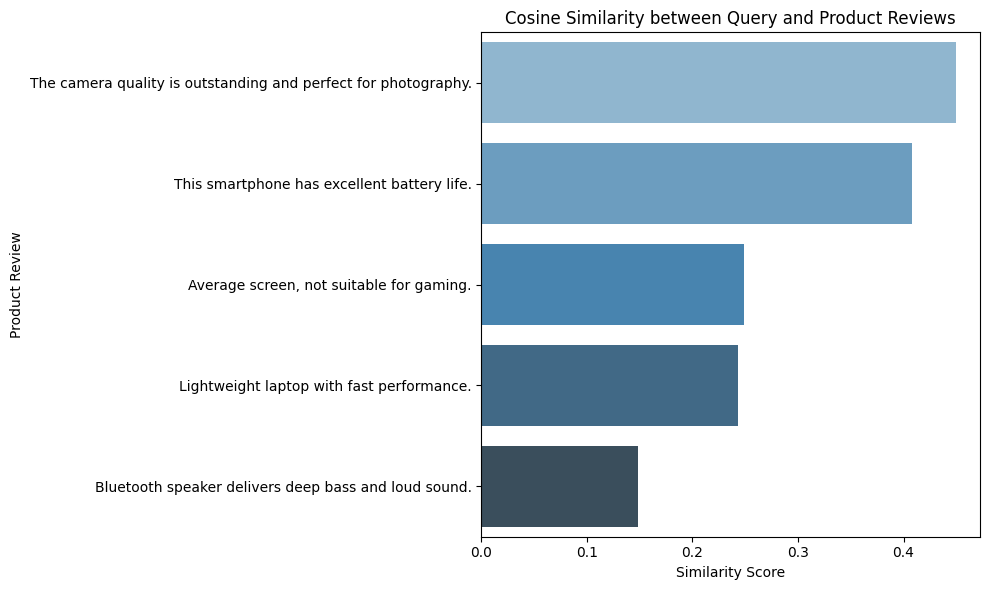

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

# Load pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Sample product reviews
reviews = [
    "This smartphone has excellent battery life.",
    "The camera quality is outstanding and perfect for photography.",
    "Lightweight laptop with fast performance.",
    "Bluetooth speaker delivers deep bass and loud sound.",
    "Average screen, not suitable for gaming.",
]

# User input/query
user_query = "Looking for a phone with a good camera"

# Encode reviews and query
review_embeddings = model.encode(reviews, convert_to_tensor=True)
query_embedding = model.encode(user_query, convert_to_tensor=True)

# Compute cosine similarities
cosine_scores = util.cos_sim(query_embedding, review_embeddings)[0].cpu().numpy()

# Create a DataFrame for visualization
df_sim = pd.DataFrame({
    'Review': reviews,
    'Cosine Similarity': cosine_scores
}).sort_values(by='Cosine Similarity', ascending=False)

# Plot the similarity scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Cosine Similarity', y='Review', data=df_sim, palette='Blues_d')
plt.title("Cosine Similarity between Query and Product Reviews")
plt.xlabel("Similarity Score")
plt.ylabel("Product Review")
plt.tight_layout()
plt.show()


/tmp/ipython-input-636179105.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="overall", palette="viridis")


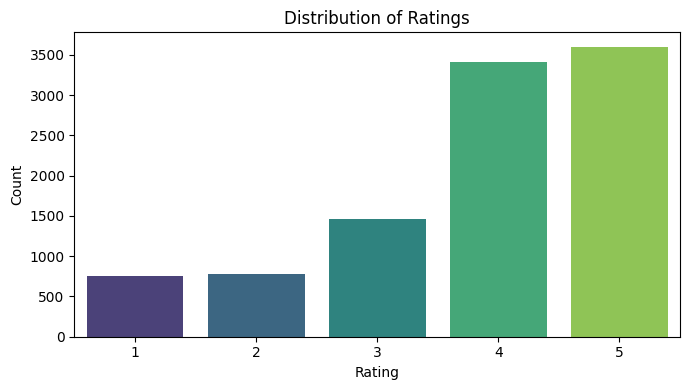

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud



# --- 1. Distribution of Ratings ---
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x="overall", palette="viridis")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



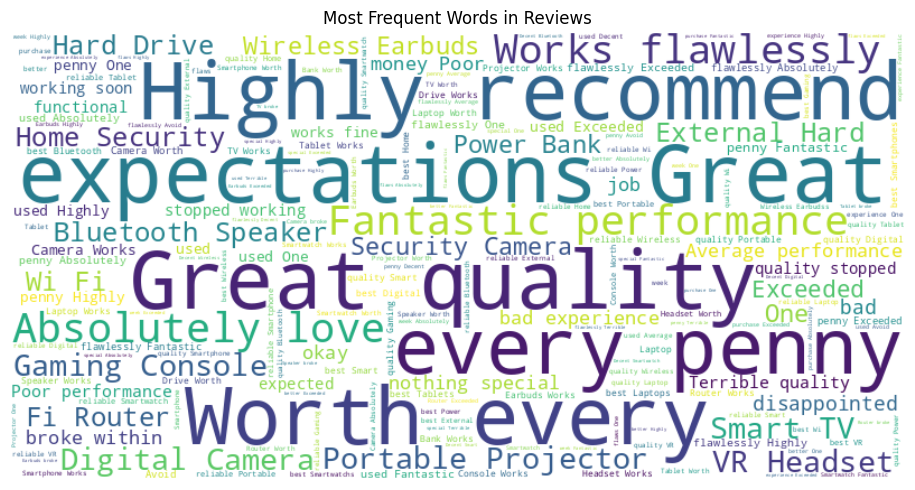

In [ ]:
# --- 2. Word Cloud for Most Common Words ---
all_reviews = " ".join(df["reviewText"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Reviews")
plt.tight_layout()
plt.show()

In [ ]:
# --- 3. Average Rating by Keyword (Top 10) ---
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_features=1000)
X = vectorizer.fit_transform(df["reviewText"])
keywords = vectorizer.get_feature_names_out()

# Create a DataFrame with keyword frequencies
keyword_freq = pd.DataFrame(X.toarray(), columns=keywords)
keyword_freq["overall"] = df["overall"].values

avg_ratings = {}
for word in keywords:
    mask = keyword_freq[word] > 0
    avg_ratings[word] = keyword_freq.loc[mask, "overall"].mean()

/tmp/ipython-input-3963251210.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ratings), y=list(words), palette="coolwarm")


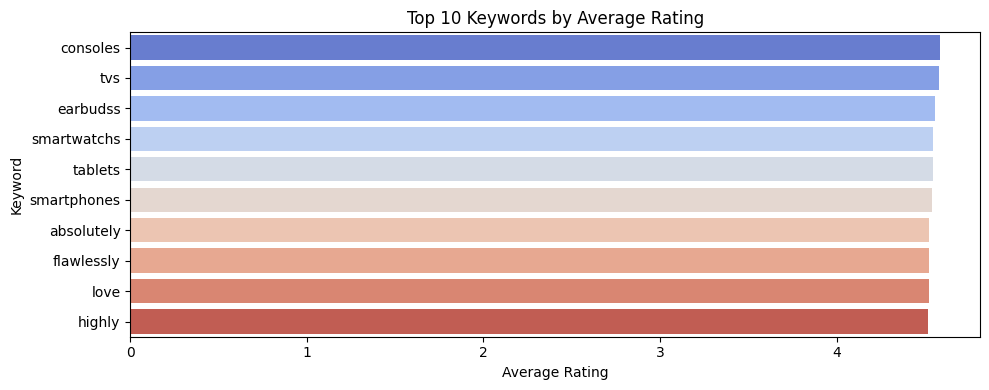

In [ ]:
# Top 10 keywords by average rating
top_keywords = sorted(avg_ratings.items(), key=lambda x: x[1], reverse=True)[:10]
words, ratings = zip(*top_keywords)

plt.figure(figsize=(10, 4))
sns.barplot(x=list(ratings), y=list(words), palette="coolwarm")
plt.title("Top 10 Keywords by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()